# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


**Описание данных:**

Данные содержатся в файле `autos.csv`.


Признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя


Целевой признак:
- `Price` — цена (евро)

**Ход исследования:**

1. **Описание проекта**
2. **Загрузка и подготовка данных.** Изучим данные и сделаем выводы. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. **Обучение моделей.** Подготовим выборки для обучения моделей.Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры. 
4. **Анализ моделей.** Проанализируем время обучения, время предсказания и качество моделей. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.
5. **Выводы.** 



**Примечания:**
- Для оценки качества моделей будем применять метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. 
- Модель градиентного бустинга может долго обучаться, поэтому изменим у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалим лишние переменные оператором del.
`del features_train`

## Подготовка данных

### Импорт библиотек и загрузка данных

Импортируем библиотеки.

In [1]:
#установим библиотеки
!pip install scikit-learn==1.4.0
!pip install shap 
!pip install phik -q
!pip install missingno
!pip install catboost
!pip install lightgbm

#стандартные библиотеки
import os
import pandas as pd 
import numpy as np
from scipy import stats as st
import time
from time import time

#библиотеки для построения графиков
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import missingno as msno

import phik

#класс для разделения на выборки
from sklearn.model_selection import train_test_split 

#загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

#загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, make_scorer, mean_squared_error, root_mean_squared_error

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix

import shap

#константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

Считаем CSV-файл с данными с помощью библиотеки pandas и сохраним его в датафрейм.

In [2]:
pth1=['/Users/margarita/Desktop/datasets/autos.csv']
pth2=['/datasets/autos.csv']

if os.path.exists(pth1[0]):
    autos = pd.read_csv(pth1[0], parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
elif os.path.exists(pth2[0]):
    autos = pd.read_csv(pth2[0], parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    print('Something is wrong in autos')

### Предобработка данных

Изучим общую информацию о датафреймах.

In [3]:
print('Вывод первых пяти строк датафрейма:\n')
autos.head(5)

Вывод первых пяти строк датафрейма:



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [4]:
print('Размер датафрейма:')
autos.shape

Размер датафрейма:


(354369, 16)

In [5]:
print('Общая информация:')
autos.info()

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 

In [6]:
print('Проверка на наличие пропусков')
autos.isna().sum()

Проверка на наличие пропусков


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

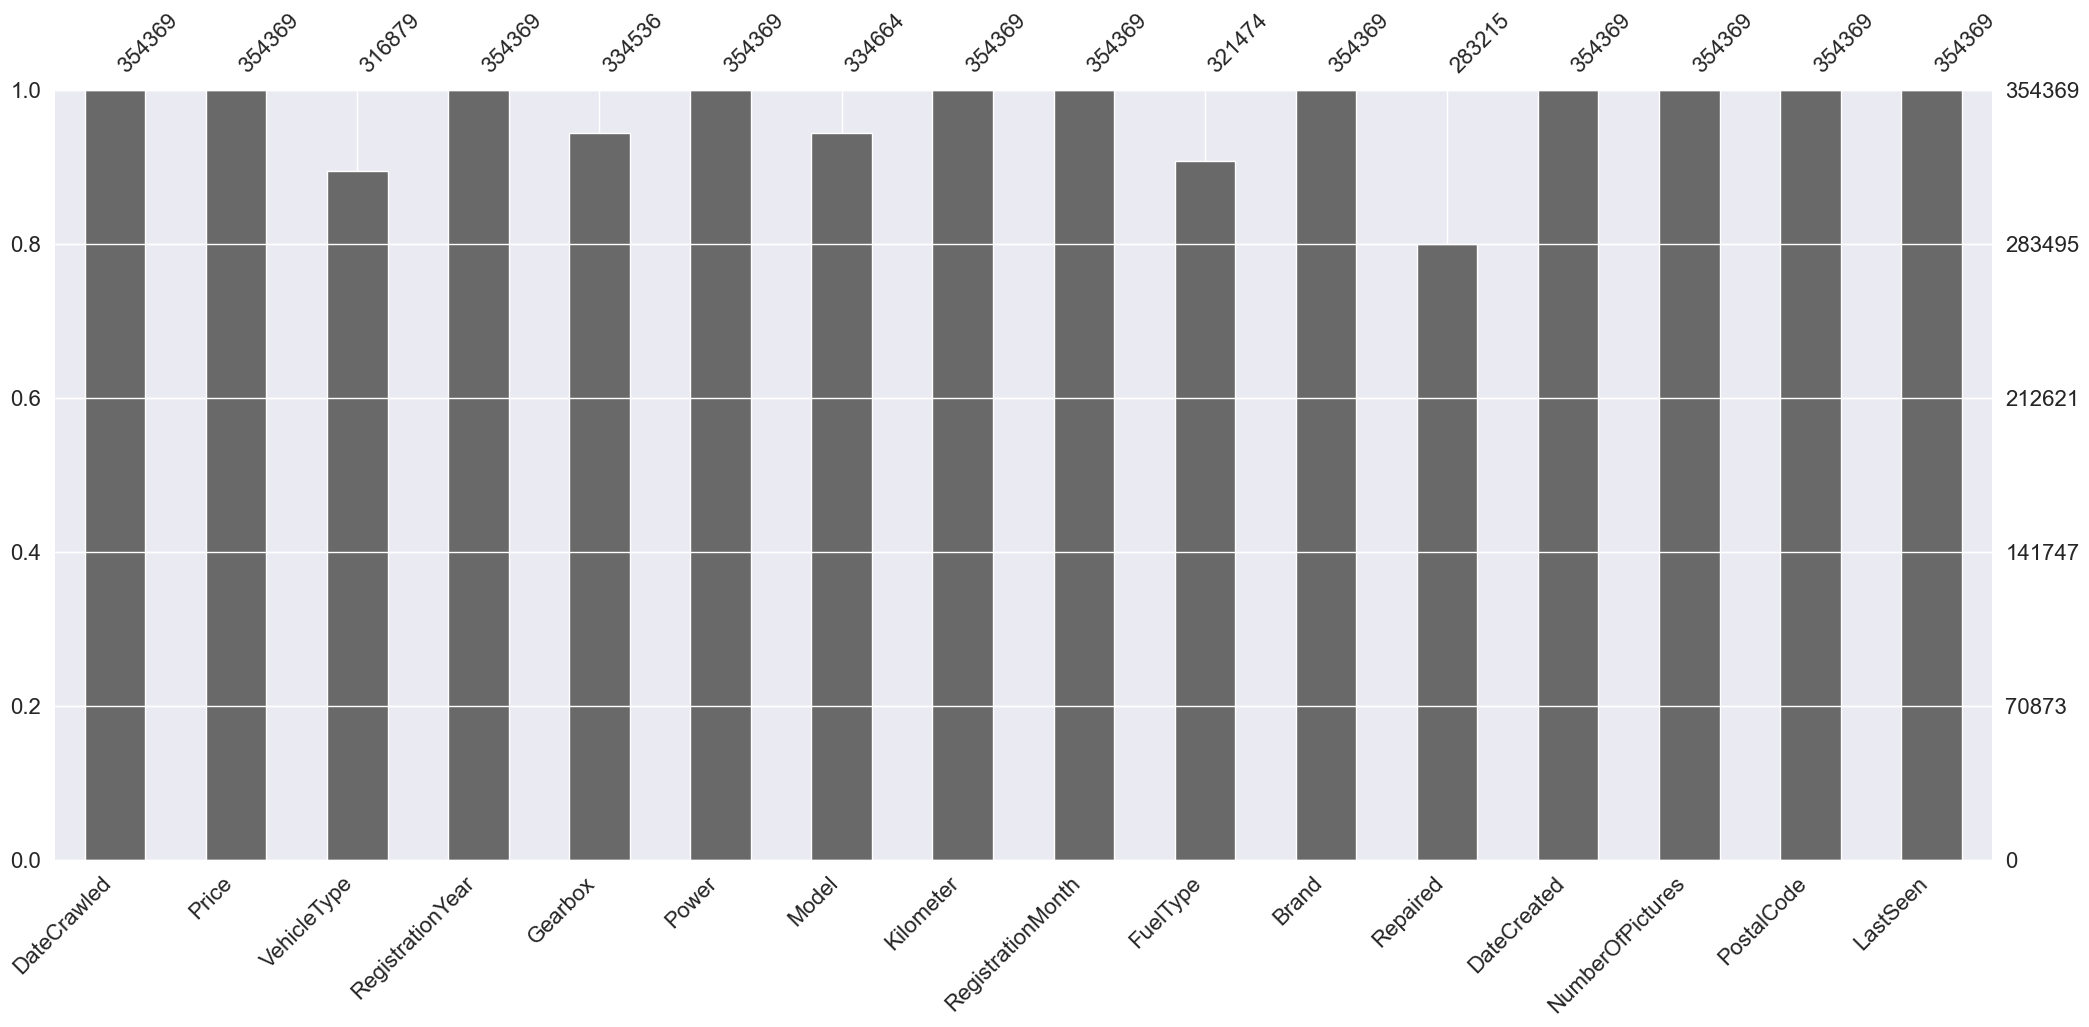

In [7]:
#визуализируем пропущенные значения
sns.set()
msno.bar(autos)
plt.show()

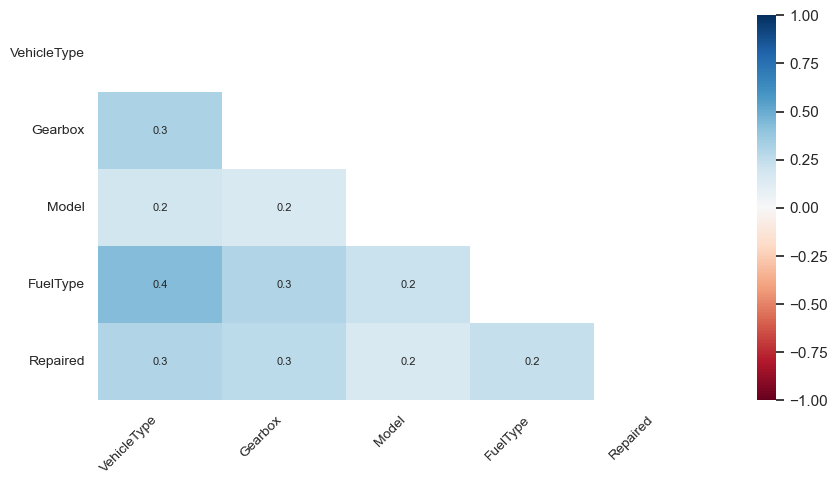

In [8]:
#визуализируем корреляцию между пропущенными значениями
msno.heatmap(autos, figsize=(10,5), fontsize=10) 
plt.show()

In [9]:
print('Проверка на наличие явных дубликатов')
autos.duplicated().sum()

Проверка на наличие явных дубликатов


4

In [10]:
print('Проверка на наличие неявных дубликатов')
for column in autos.columns.tolist():
    print(f'{column}'.split('=')[0]) 
    print(autos[column].unique())

Проверка на наличие неявных дубликатов
DateCrawled
<DatetimeArray>
['2016-03-24 11:52:17', '2016-03-24 10:58:45', '2016-03-14 12:52:21',
 '2016-03-17 16:54:04', '2016-03-31 17:25:20', '2016-04-04 17:36:23',
 '2016-04-01 20:48:51', '2016-03-21 18:54:38', '2016-04-04 23:42:13',
 '2016-03-17 10:53:50',
 ...
 '2016-03-16 17:06:19', '2016-04-02 16:43:27', '2016-03-06 21:11:23',
 '2016-04-04 11:45:16', '2016-04-04 09:57:12', '2016-03-09 13:37:43',
 '2016-03-19 19:53:49', '2016-03-21 09:50:58', '2016-03-14 17:48:27',
 '2016-03-19 18:57:12']
Length: 271174, dtype: datetime64[ns]
Price
[  480 18300  9800 ... 12395 18429 10985]
VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972

Удалим явные дубликаты.

In [11]:
#удалим явные дубликаты
autos = autos.drop_duplicates()
autos = autos.reset_index(drop=True)

Поправим неявные дубликаты в столбце `FuelType`.

In [12]:
autos['FuelType'] = autos['FuelType'].replace('gasoline', 'petrol')

Удалим неинформативные признаки, которые не оказывают влияния на рыночную стоимость автомобиля:
- `DateCrawled` — дата скачивания анкеты из базы
- `RegistrationMonth` — месяц регистрации автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `DateCreated` — дата создания анкеты

Кроме того, удалим неинформативный признак `NumberOfPictures` — количество фотографий автомобиля, так как в данных отсуствует эта информация по всем автомобилям (везде указан 0).

In [13]:
autos = autos.drop(columns=['DateCrawled', 'RegistrationMonth', 'PostalCode', 'LastSeen', 
                            'DateCreated', 'NumberOfPictures'], axis=1).reset_index(drop=True)
autos.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


### Анализ количественных переменных

In [14]:
#вывод описательных статистик
autos.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


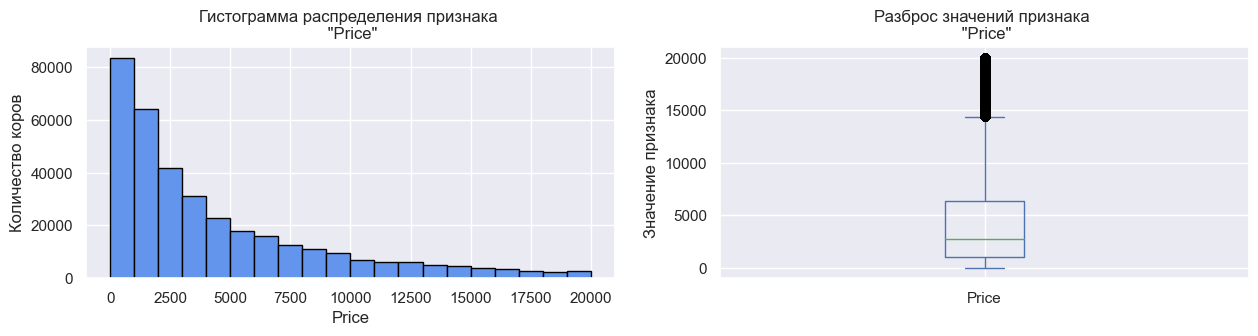

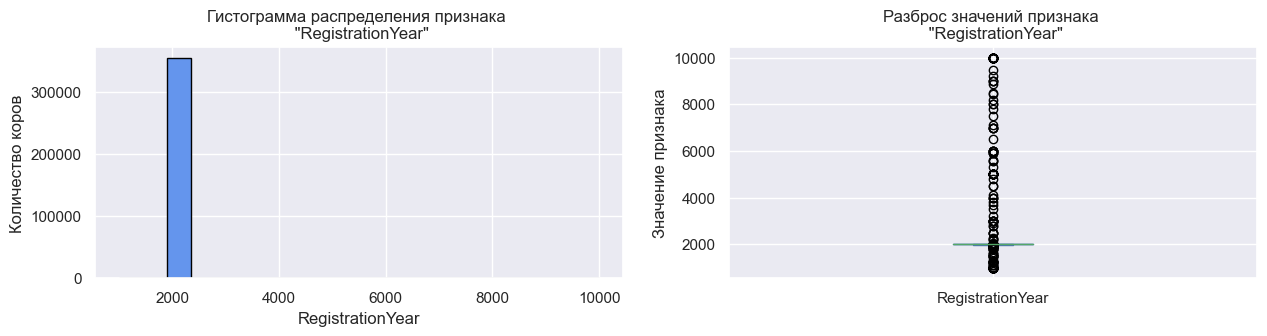

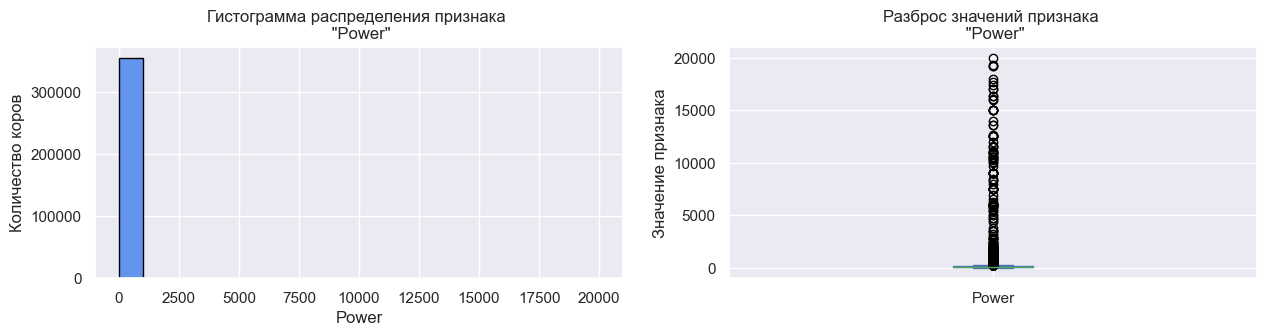

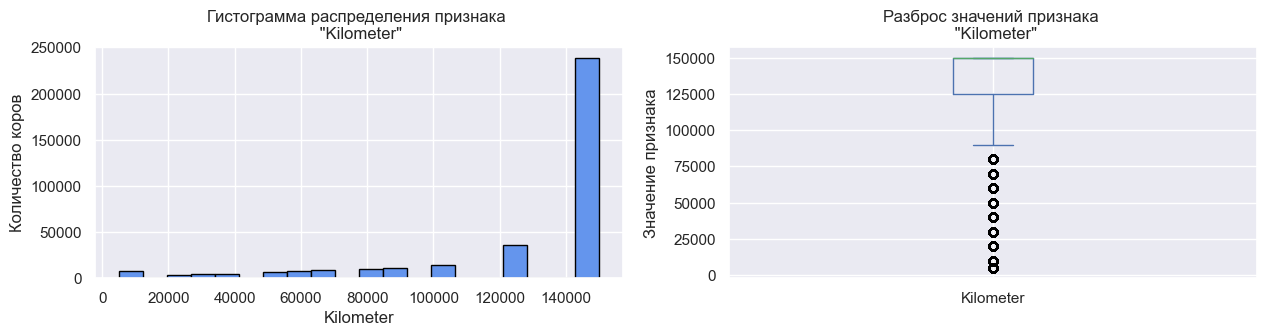

In [15]:
col_names = autos.select_dtypes(include='number').columns

for col in col_names:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
    autos[col].plot(kind='hist', bins=20, ax=axes[0], color='cornflowerblue', edgecolor = 'black')
    axes[0].set_title(f'Гистограмма распределения признака \n "{col}"')
    axes[0].set_xlabel(f'{col}')
    axes[0].set_ylabel('Количество коров')
    
    autos[col].plot(kind='box', ax=axes[1])
    axes[1].set_title(f'Разброс значений признака \n "{col}"')
    axes[1].set_ylabel('Значение признака')
    plt.show()

Удалим аномальные значения по признакам:
- `RegistrationYear` — год регистрации автомобиля
- `Power` — мощность (л. с.)

In [16]:
autos = autos.query('Power <= 1000').query('RegistrationYear <= 2016')

### Анализ качественных переменных

Построим круговые диаграммы для качественных признаков.
Признаки `Model` и `Brand` рассмотрим отдельно ввиду неудобства рассмотрения их на круговых диаграммах.

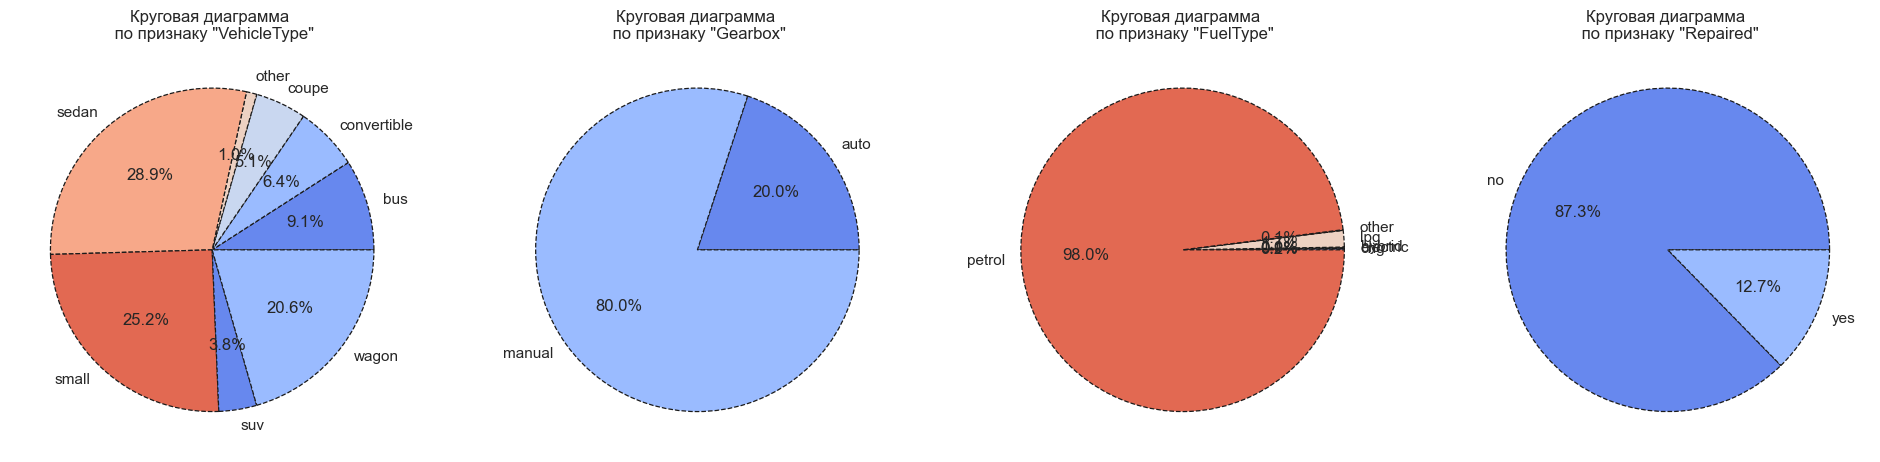

In [17]:
col_names = autos.drop(columns=['Model', 'Brand'], axis=1).select_dtypes(exclude='number').columns

#функция для вывода количества по каждому типу категориальных переменных
#и для построения круговых диаграмм
        
fig, axes = plt.subplots(nrows=1, ncols=len(col_names), figsize=(24, 6))
colors = sns.color_palette('coolwarm')[0:7]

for i in range (len(col_names)):
    #если признаков больше 1
    if len(col_names)> 1:
        autos.groupby(col_names[i]).size().plot(kind='pie', subplots=True, figsize=(8, 8), colors = colors, 
                                                   autopct='%1.1f%%', ax=axes[i], ylabel='', 
                                                   wedgeprops={'lw':0.9, 'ls':'--','edgecolor':"k"},)
        axes[i].set_title(f'Круговая диаграмма \n по признаку "{col_names[i]}"')
        #если признак 1
    elif len(col_names)==1:
        autos.groupby(col_names[i]).size().plot(kind='pie', figsize=(4, 4), colors = colors, autopct='%1.1f%%', ylabel='', 
                                                   title=f'Круговая диаграмма \n по признаку "{col_names[i]}"',
                                                   wedgeprops={'lw':0.9, 'ls':'--','edgecolor':"k"},)
plt.show()

In [18]:
print('Количество моделей автомобилей:', len(autos['Model'].unique()))
print('\nПять наиболее популярных моделей автомобилей:\n', autos['Model'].value_counts().head())

Количество моделей автомобилей: 251

Пять наиболее популярных моделей автомобилей:
 Model
golf     27605
other    23862
3er      19211
polo     12442
corsa    11930
Name: count, dtype: int64


In [19]:
print('Количество брендов автомобилей:', len(autos['Brand'].unique()))
print('\nПять наиболее популярных брендов автомобилей:\n', autos['Brand'].value_counts().head())

Количество брендов автомобилей: 40

Пять наиболее популярных брендов автомобилей:
 Brand
volkswagen       73140
opel             37962
bmw              35774
mercedes_benz    30982
audi             28459
Name: count, dtype: int64


### Корреляционный анализ

Проведем корреляционный анализ признаков в количественной шкале. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

In [20]:
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


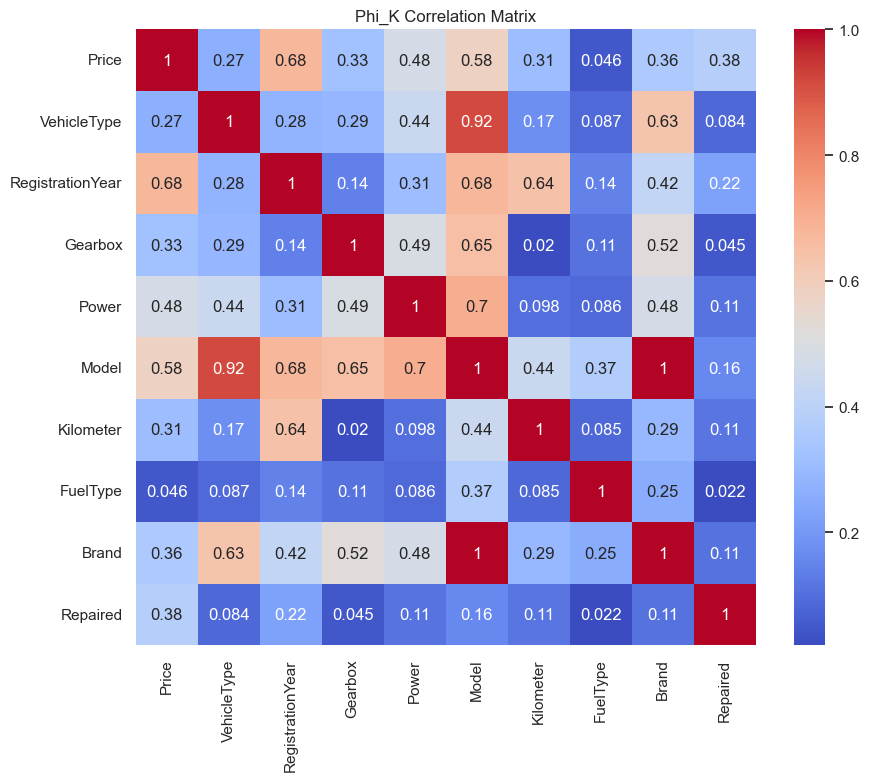

In [21]:
#вычислим матрицы корреляции с использованием phik
#при использовании phik настроим параметр interval_cols, передав ему список 
##с названиями непрерывных признаков

corr_matrix = autos.phik_matrix(interval_cols=['Price','Power', 'Kilometer'])

#визуализируем матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

**Вывод:** Высокую корреляцию можно заметить у признаков `VehicleType` и `Model`. Кроме того, заметная корреляция также наблюдается у признаков `RegistrationYear` и `Kilometer`, `Model` и `Price`, `Model` и `RegistrationYear`, `Model` и `Gearbox`, `Model` и `Power`, `Model` и `FuelType`. Однако удалять какой-либо из этих признаков будет неправильно, так как они все каким-то образом оказывают влияние на стоимость и вносят свои поправки. Данная корреляция пригодится нам для последующего заполнения пропусков.

### Заполнение пропусков

In [22]:
print('Проверка на наличие пропусков')
autos.isna().sum()

Проверка на наличие пропусков


Price                   0
VehicleType         22956
RegistrationYear        0
Gearbox             17952
Power                   0
Model               17625
Kilometer               0
FuelType            27255
Brand                   0
Repaired            64756
dtype: int64

Строки с пропусками в столбце с моделью исключим. Пропуски в других колонках также дублируются, поэтому такие записи не совсем информативны.

In [23]:
autos = autos.dropna(subset=['Model'])

Пропуски в следующих столбцах можно заполнить в соответствии с моделью автомобиля `Model`:
- `VehicleType` — тип автомобильного кузова
- `FuelType` — тип топлива
- `Gearbox` — тип коробки передач

In [24]:
for model in autos.dropna(subset=['Model'])['Model'].unique():
    autos.loc[(autos['Model'] == model) & (autos['VehicleType'].isna()), 'VehicleType'] = \
    autos.dropna(subset=['VehicleType']).loc[(autos['Model'] == model), 'VehicleType'].reset_index(drop=True)[0][:]
    
    autos.loc[(autos['Model'] == model) & (autos['FuelType'].isna()), 'FuelType'] = \
    autos.dropna(subset=['FuelType']).loc[(autos['Model'] == model), 'FuelType'].reset_index(drop=True)[0][:]
    
    autos.loc[(autos['Model'] == model) & (autos['Gearbox'].isna()), 'Gearbox'] = \
    autos.dropna(subset=['Gearbox']).loc[(autos['Model'] == model), 'Gearbox'].reset_index(drop=True)[0][:]

In [25]:
autos.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
Repaired            56674
dtype: int64

Вычислим количество оставшихся пропусков в процентах.

In [26]:
pd.DataFrame(round(autos.isna().mean()*100)).style.background_gradient('coolwarm')

,0
Price,0.000000
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
FuelType,0.000000
Brand,0.000000
Repaired,18.000000


Пропуски в столбце `Repaired` заполним заглушкой `NA`.

In [27]:
autos.loc[autos['Repaired'].isna(), 'Repaired'] = 'NA'

В  проекте стоит вопрос о выборе модели в том числе на основе затраченного времени.
Сожмем датасет, приведя его в более экономный тип.

In [28]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [29]:
autos = optimize_memory_usage(autos)

Размер использования памяти: до 35.08 Mb - после 28.33 Mb (19.3%)


**Выводы:**
В данных содержалось 354369 записей. Выполнена подготовка данных:
1. Исключены неинформативные признаки, которые не оказывают влияния на рыночную стоимость автомобиля: `DateCrawled` — дата скачивания анкеты из базы, `RegistrationMonth` — месяц регистрации автомобиля, `PostalCode` — почтовый индекс владельца анкеты (пользователя), `LastSeen` — дата последней активности пользователя, `DateCreated` — дата создания анкеты. Был удален также неинформативный признак `NumberOfPictures` — количество фотографий автомобиля, так как в данных отсуствует эта информация по всем автомобилям (везде указан 0). 
2. Удалены явные дубликаты.
3. Устранены неявные дубликаты в стоблце `FuelType`.
4. Проведен корреляционный анализ. Высокую корреляцию можно заметить у признаков `VehicleType` и `Model`. Кроме того, заметная корреляция также наблюдается у признаков `RegistrationYear` и `Kilometer`, `Model` и `Price`, `Model` и `RegistrationYear`, `Model` и `Gearbox`, `Model` и `Power`, `Model` и `FuelType`. Однако удалять какой-либо из этих признаков будет неправильно, так как они все каким-то образом оказывают влияние на стоимость и вносят свои поправки. Данная корреляция пригодилась нам для последующего заполнения пропусков.
5. Заполнены пропуски в соответствии с моделью автомобиля `Model` в столбцах: `VehicleType` — тип автомобильного кузова, `FuelType` — тип топлива, `Gearbox` — тип коробки передач. 
6. Удалены аномальные значения по признакам: `RegistrationYear` — год регистрации автомобиля, `Power` — мощность (л. с.).
7. Ввиду дальнейшего выбора модели в том числе на основе затраченного времени, датасет был сжат и приведен в более экономный тип.

## Обучение моделей

Рассмотрим обработанный датасет.

In [30]:
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,small,1993,manual,0,golf,150000,petrol,volkswagen,NA
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,NA
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [31]:
# создадим списки с названиями признаков

#категориальные категории
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

#количественные признаки
num_features = ['RegistrationYear', 'Power', 'Kilometer'] 

In [32]:
#разобьем датасет на тренировочную и тестовую выборки
X = autos.drop(columns=['Price'], axis=1)
y = autos['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

Далее обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры. Проанализируем время обучения, время предсказания и качество моделей.

### CatBoost

С помощью GridSearchCV выполним автоматизированный поиск гиперпараметров.

In [33]:
#создадим функцию для расчета метрики RMSE
def rmse_score(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

scorer = make_scorer(rmse_score, greater_is_better=False)

In [34]:
#зададим модель и параметры
model = CatBoostRegressor(random_state=RANDOM_STATE, iterations=40, cat_features=cat_features)

parameters = {
    'simple_ctr': ['Buckets', 'BinarizedTargetMeanValue', 'Counter'],
    'combinations_ctr': ['Buckets', 'BinarizedTargetMeanValue', 'Counter'],
    'max_depth': range(1, 3)
}

gs = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,
    cv=5,
    scoring=scorer
)

Обучим модель.

In [35]:
%%time

gs.fit(X_train, y_train) 

Learning rate set to 0.5
0:	learn: 3604.1790274	total: 65.6ms	remaining: 2.56s
1:	learn: 3186.6763950	total: 70.8ms	remaining: 1.34s
2:	learn: 2953.6428563	total: 77.4ms	remaining: 954ms
3:	learn: 2779.4247424	total: 82.8ms	remaining: 745ms
4:	learn: 2659.6550618	total: 88.4ms	remaining: 619ms
5:	learn: 2551.9071316	total: 95.1ms	remaining: 539ms
6:	learn: 2481.2967873	total: 103ms	remaining: 486ms
7:	learn: 2407.9163271	total: 108ms	remaining: 432ms
8:	learn: 2375.6484900	total: 113ms	remaining: 388ms
9:	learn: 2353.7294844	total: 117ms	remaining: 352ms
10:	learn: 2330.4686640	total: 121ms	remaining: 320ms
11:	learn: 2316.1726633	total: 126ms	remaining: 294ms
12:	learn: 2296.1350514	total: 132ms	remaining: 274ms
13:	learn: 2275.4539180	total: 137ms	remaining: 254ms
14:	learn: 2262.5481051	total: 141ms	remaining: 235ms
15:	learn: 2242.8987777	total: 146ms	remaining: 219ms
16:	learn: 2235.7509582	total: 151ms	remaining: 204ms
17:	learn: 2226.8615339	total: 156ms	remaining: 190ms
18:	lea

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x16a219a50>,
             n_jobs=-1,
             param_grid={'combinations_ctr': ['Buckets',
                                              'BinarizedTargetMeanValue',
                                              'Counter'],
                         'max_depth': range(1, 3),
                         'simple_ctr': ['Buckets', 'BinarizedTargetMeanValue',
                                        'Counter']},
             scoring=make_scorer(rmse_score, greater_is_better=False, response_method='predict'))

In [36]:
print('Лучшая модель:', gs.best_estimator_)
print('Лучшие гиперпараметры модели:', gs.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', abs(gs.best_score_.round(2)))
rmse_cb = abs(gs.best_score_.round(2))

Лучшая модель: <catboost.core.CatBoostRegressor object at 0x16c1f7010>
Лучшие гиперпараметры модели: {'combinations_ctr': 'Buckets', 'max_depth': 2, 'simple_ctr': 'BinarizedTargetMeanValue'}
Метрика лучшей модели при кросс-валидации: 2104.31


In [37]:
#зададим отдельно лучшую модель
model_cb = gs.best_estimator_

In [38]:
#найдем время обучения конкретно этой модели в минутах
#%time
start = time()
model_cb.fit(X_train, y_train)
end = time()
cb_training_time = (end-start)/60 

Learning rate set to 0.5
0:	learn: 3604.1790274	total: 7.35ms	remaining: 287ms
1:	learn: 3186.6763950	total: 13.2ms	remaining: 251ms
2:	learn: 2953.6428563	total: 21.4ms	remaining: 263ms
3:	learn: 2779.4247424	total: 27.1ms	remaining: 244ms
4:	learn: 2659.6550618	total: 32.2ms	remaining: 225ms
5:	learn: 2551.9071316	total: 38.2ms	remaining: 216ms
6:	learn: 2481.2967873	total: 46.4ms	remaining: 219ms
7:	learn: 2407.9163271	total: 51ms	remaining: 204ms
8:	learn: 2375.6484900	total: 55.3ms	remaining: 190ms
9:	learn: 2353.7294844	total: 59.6ms	remaining: 179ms
10:	learn: 2330.4686640	total: 64ms	remaining: 169ms
11:	learn: 2316.1726633	total: 68.5ms	remaining: 160ms
12:	learn: 2296.1350514	total: 74.4ms	remaining: 154ms
13:	learn: 2275.4539180	total: 79ms	remaining: 147ms
14:	learn: 2262.5481051	total: 83.6ms	remaining: 139ms
15:	learn: 2242.8987777	total: 88.3ms	remaining: 132ms
16:	learn: 2235.7509582	total: 93.1ms	remaining: 126ms
17:	learn: 2226.8615339	total: 97.7ms	remaining: 119ms
1

In [39]:
start = time()
model_cb.predict(X_train)
end = time()
cb_prediction_time = (end-start)/60 

### LightGBM

Для LightGBM предварительно приведет категориальные признаки к типу category (.astype('category')), чтобы модель обрабатывала их как категориальные.

In [40]:
X_train_lgbm = X_train

X_train_lgbm[cat_features] = X_train_lgbm[cat_features].astype('category')

In [41]:
#зададим модель и параметры
model = LGBMRegressor(random_state=RANDOM_STATE)

parameters = {
    'num_leaves':range(8,12),
    'max_depth': range(4, 8),
    'n_estimators': range(26, 33)
}

gs = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,
    cv=5,
    scoring=scorer
)

In [42]:
%%time

gs.fit(X_train_lgbm, y_train) 

Learning rate set to 0.5
0:	learn: 3898.9991534	total: 98.8ms	remaining: 3.85s
1:	learn: 3558.6284259	total: 125ms	remaining: 2.37s
2:	learn: 3344.2508055	total: 157ms	remaining: 1.94s
3:	learn: 3208.3333094	total: 188ms	remaining: 1.69s
4:	learn: 3107.9878438	total: 222ms	remaining: 1.56s
5:	learn: 3006.0309512	total: 261ms	remaining: 1.48s
6:	learn: 2929.3385098	total: 276ms	remaining: 1.3s
7:	learn: 2854.0139099	total: 296ms	remaining: 1.18s
8:	learn: 2805.1909081	total: 321ms	remaining: 1.1s
9:	learn: 2757.6242382	total: 364ms	remaining: 1.09s
10:	learn: 2706.1029705	total: 392ms	remaining: 1.03s
11:	learn: 2661.6385763	total: 418ms	remaining: 974ms
12:	learn: 2624.1807046	total: 440ms	remaining: 915ms
13:	learn: 2599.5867167	total: 467ms	remaining: 868ms
14:	learn: 2576.3065960	total: 501ms	remaining: 835ms
15:	learn: 2552.2591227	total: 537ms	remaining: 805ms
16:	learn: 2530.7074751	total: 559ms	remaining: 757ms
17:	learn: 2513.4971613	total: 575ms	remaining: 703ms
18:	learn: 248

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(4, 8),
                         'n_estimators': range(26, 33),
                         'num_leaves': range(8, 12)},
             scoring=make_scorer(rmse_score, greater_is_better=False, response_method='predict'))

In [43]:
print('Лучшая модель:', gs.best_estimator_)
print('Лучшие гиперпараметры модели:', gs.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', abs(gs.best_score_.round(2)))

rmse_lgbm = abs(gs.best_score_.round(2))

Лучшая модель: LGBMRegressor(max_depth=7, n_estimators=32, num_leaves=11, random_state=42)
Лучшие гиперпараметры модели: {'max_depth': 7, 'n_estimators': 32, 'num_leaves': 11}
Метрика лучшей модели при кросс-валидации: 1986.92


In [44]:
#зададим отдельно лучшую модель 
model_lgbm = gs.best_estimator_

In [45]:
#найдем время обучения конкретно этой модели в минутах
%time

start = time()
model_lgbm.fit(X_train_lgbm, y_train)
end = time()
lgbm_training_time = (end-start)/60 

CPU times: user 9 µs, sys: 8 µs, total: 17 µs
Wall time: 3.81 µs
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 241446, number of used features: 9
[LightGBM] [Info] Start training from score 4556.913409


In [46]:
start = time()
model_lgbm.predict(X_train)
end = time()
lgbm_prediction_time = (end-start)/60 

### DecisionTreeRegressor

Выполним подготовку признаков (кодирование). В случае модели на основе деревьев решений нет нужды масштабировать количественные признаки.

In [47]:
X_train[cat_features] = X_train[cat_features].astype('str')

In [48]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
X_train_dt = X_train
X_train_dt[cat_features] = ordinal_encoder.fit_transform(X_train_dt[cat_features])

In [49]:
#зададим модель и параметры
model = DecisionTreeRegressor(random_state=RANDOM_STATE)

parameters = {
    'max_depth': range(1, 10),
    'min_samples_split': range(1, 10),
    'min_samples_leaf': range(1, 5),
}

rs = RandomizedSearchCV(
    model, 
    parameters, 
    cv=20,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [50]:
%%time

rs.fit(X_train_dt, y_train)

/Users/margarita/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/margarita/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/margarita/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/Users/margarita/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constrain

CPU times: user 596 ms, sys: 425 ms, total: 1.02 s
Wall time: 4.21 s


RandomizedSearchCV(cv=20, estimator=DecisionTreeRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 10),
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(1, 10)},
                   random_state=42,
                   scoring=make_scorer(rmse_score, greater_is_better=False, response_method='predict'))

In [51]:
print('Лучшая модель:', rs.best_estimator_)
print('Лучшие гиперпараметры модели:', rs.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', abs(rs.best_score_.round(2)))

rmse_dt = abs(rs.best_score_.round(2))

Лучшая модель: DecisionTreeRegressor(max_depth=8, min_samples_leaf=2, min_samples_split=6,
                      random_state=42)
Лучшие гиперпараметры модели: {'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 8}
Метрика лучшей модели при кросс-валидации: 2188.24


In [52]:
#зададим отдельно лучшую модель 
model_dt = rs.best_estimator_

In [53]:
#найдем время обучения конкретно этой модели в минутах

start = time()
model_dt.fit(X_train, y_train)
end = time()
dt_training_time = (end-start)/60 

In [54]:
start = time()
model_dt.predict(X_train)
end = time()
dt_prediction_time = (end-start)/60 

### LinearRegression

In [55]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_features])
encoder_col_names = encoder.get_feature_names_out()

In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_features])

In [57]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_features)

X_train_lr = pd.concat([X_train_ohe, X_train_scaled], axis=1)

X_train_lr.head()

,VehicleType_1.0,VehicleType_2.0,VehicleType_3.0,VehicleType_4.0,VehicleType_5.0,VehicleType_6.0,VehicleType_7.0,Gearbox_1.0,Model_1.0,Model_2.0,...,Brand_34.0,Brand_35.0,Brand_36.0,Brand_37.0,Brand_38.0,Repaired_1.0,Repaired_2.0,RegistrationYear,Power,Kilometer
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.427495,0.648009,0.57877
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.039217,-0.129884,0.57877
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.039217,0.346377,0.57877
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.599270,0.489255,0.57877
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.147468,-0.368015,0.57877


In [58]:
#зададим модель и параметры
model_lr = LinearRegression()

In [59]:
start = time()
model_lr.fit(X_train_lr, y_train)
end = time()
lr_training_time = (end-start)/60 

In [60]:
start = time()
y_train_pred = model_lr.predict(X_train_lr)
end = time()
lr_prediction_time = (end-start)/60 

In [61]:
print ('Метрика модели на тренировочной выборке:', rmse_score(y_train, y_train_pred).round(2))

rmse_lr = rmse_score(y_train, y_train_pred).round(2)

Метрика модели на тренировочной выборке: 2979.86


In [62]:
print('CatBoost')
print('Mетрика модели на тренировочных данных при кросс-валидации: RMSE =', rmse_cb)
print('Время обучения модели =', round(cb_training_time, 4), 'минут')
print('Время предсказания модели =', round(cb_prediction_time, 4), 'минут\n\n')

print('LightGBM')
print('Mетрика модели на тренировочных данных при кросс-валидации: RMSE =', rmse_lgbm)
print('Время обучения модели =', round(lgbm_training_time, 4), 'минут')
print('Время предсказания модели =', round(lgbm_prediction_time, 4), 'минут\n\n')

print('DecisionTreeRegressor')
print('Mетрика модели на тренировочных данных при кросс-валидации: RMSE =', rmse_dt)
print('Время обучения модели =', round(dt_training_time, 4), 'минут')
print('Время предсказания модели =', round(dt_prediction_time, 4), 'минут\n\n')

print('LinearRegression')
print('Mетрика модели на тренировочных данных при кросс-валидации: RMSE =', rmse_lr)
print('Время обучения модели =', round(lr_training_time, 4), 'минут')
print('Время предсказания модели =', round(lr_prediction_time, 4), 'минут\n\n')

CatBoost
Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 2104.31
Время обучения модели = 0.0051 минут
Время предсказания модели = 0.0009 минут


LightGBM
Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 1986.92
Время обучения модели = 0.0019 минут
Время предсказания модели = 0.0005 минут


DecisionTreeRegressor
Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 2188.24
Время обучения модели = 0.0032 минут
Время предсказания модели = 0.0002 минут


LinearRegression
Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 2979.86
Время обучения модели = 0.0383 минут
Время предсказания модели = 0.002 минут




## Анализ моделей

Опираясь на критерии заказчика, выберем лучшую модель.
Критерии, которые были важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Исследуемые модели показали следующий результат: 
- CatBoost
  - Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 2104.31
  - Время обучения модели = 0.0051 минут
  - Время предсказания модели = 0.0009 минут
- LightGBM
  - Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 1986.92
  - Время обучения модели = 0.0019 минут
  - Время предсказания модели = 0.0005 минут
- DecisionTreeRegressor
  - Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 2188.24
  - Время обучения модели = 0.0032 минут
  - Время предсказания модели = 0.0002 минут
- LinearRegression
  - Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 2979.86
  - Время обучения модели = 0.0383 минут
  - Время предсказания модели = 0.002 минут

Таким образом, была выбрана лучшая модель - LightGBM, которая показала лучшее соотношение между временем обучения и предсказания модели, а также качеством предсказания. 

Выполним предсказания и расчет метрики RMSE лучшей модели на тестовой выборке.

In [63]:
X_test[cat_features] = X_test[cat_features].astype('category')

In [64]:
#предсказания
y_pred = model_lgbm.predict(X_test)

print ('Метрика лучшей модели на тестовой выборке:', rmse_score(y_test, y_pred).round(2))

Метрика лучшей модели на тестовой выборке: 1990.02
[LightGBM] [Info] Start training from score 4551.425074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 193157, number of used features: 9
[LightGBM] [Info] Start training from score 4561.549900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 193156, number of used features: 9
[LightGBM] [Info] Start training from score 4555.439551
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of tes

Данная метрика показывает значение, близкое к метрике на тренировочных данных. Таким образом, выбор лучшей модели подтвержден.

## Выводы

В исследовании необходимо было разработать модель, которая умеет определять рыночную стоимость автомобиля.
У нас были данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые были важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Выводы:**
1. В данных содержалось 354369 записей. Выполнена подготовка данных:
  - Исключены неинформативные признаки, которые не оказывают влияния на рыночную стоимость автомобиля: `DateCrawled` — дата скачивания анкеты из базы, `RegistrationMonth` — месяц регистрации автомобиля, `PostalCode` — почтовый индекс владельца анкеты (пользователя), `LastSeen` — дата последней активности пользователя, `DateCreated` — дата создания анкеты. Был удален также неинформативный признак `NumberOfPictures` — количество фотографий автомобиля, так как в данных отсуствует эта информация по всем автомобилям (везде указан 0). 
  - Удалены явные дубликаты.
  - Устранены неявные дубликаты в стоблце `FuelType`.
  - Проведен корреляционный анализ. Высокую корреляцию можно заметить у признаков `VehicleType` и `Model`. Кроме того, заметная корреляция также наблюдается у признаков `RegistrationYear` и `Kilometer`, `Model` и `Price`, `Model` и `RegistrationYear`, `Model` и `Gearbox`, `Model` и `Power`, `Model` и `FuelType`. Однако удалять какой-либо из этих признаков будет неправильно, так как они все каким-то образом оказывают влияние на стоимость и вносят свои поправки. Данная корреляция пригодилась нам для последующего заполнения пропусков.
  - Заполнены пропуски в соответствии с моделью автомобиля `Model` в столбцах: `VehicleType` — тип автомобильного кузова, `FuelType` — тип топлива, `Gearbox` — тип коробки передач. 
  - Удалены аномальные значения по признакам: `RegistrationYear` — год регистрации автомобиля, `Power` — мощность (л. с.)
  - Ввиду дальнейшего выбора модели в том числе на основе затраченного времени, датасет был сжат и приведен в более экономный тип.
  2. Была выполнена подготовка признаков. При кодировании были учтены особенности признаков и моделей.С целью предсказания рыночную стоимости автомобиля были обучены модели CatBoost, LightGBM, DecisionTreeRegressor, LinearRegression. Для моделей были рассмотрены разные гиперпараметры. Был проведен анализ времени обучения, времени предсказания и качества моделей. Метрикой качества модели была выбрана RMSE. Опираясь на критерии заказчика, была выбрана лучшая модель, проверено её качество на тестовой выборке.
Критерии, которые были важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Исследуемые модели показали следующий результат: 
- CatBoost
  - Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 2104.31
  - Время обучения модели = 0.0051 минут
  - Время предсказания модели = 0.0009 минут
- LightGBM
  - Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 1986.92
  - Время обучения модели = 0.0019 минут
  - Время предсказания модели = 0.0005 минут
- DecisionTreeRegressor
  - Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 2188.24
  - Время обучения модели = 0.0032 минут
  - Время предсказания модели = 0.0002 минут
- LinearRegression
  - Mетрика модели на тренировочных данных при кросс-валидации: RMSE = 2979.86
  - Время обучения модели = 0.0383 минут
  - Время предсказания модели = 0.002 минут

   Таким образом, была выбрана лучшая модель - LightGBM, которая показала лучшее соотношение между временем обучения и предсказания модели, а также качеством предсказания на тренировочной и тестовой выборках.